## Galaxy-Galaxy Lenses with Power-Law - Full Sky Area 20,000 sq.deg
Author: Paras Sharma

We generate galaxy galaxy lenses population here.

In [12]:
# Standard imports
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Astropy imports
from astropy.io import fits
from astropy import units as u
from astropy.table import Table, vstack
from astropy.units import Quantity
from astropy import constants as const
import corner

# SLSim imports
import slsim.Pipelines as pipelines
import slsim.Sources as sources
import slsim.Deflectors as deflectors
from slsim.Lenses.lens_pop import LensPop
from slsim.Plots.lens_plots import LensingPlots
from slsim.Lenses.lens import Lens
from slsim.LOS.los_pop import LOSPop

# Lenstronomy, HierArc imports
from lenstronomy.LensModel.lens_model import LensModel
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam

from slsim.ImageSimulation.image_simulation import simulate_image, rgb_image_from_image_list

from warnings import filterwarnings
filterwarnings("ignore")

In [3]:
PROJECT_DIR = "~/Projects/PDSPL/pdspl-analysis/"

## Generate SLSim Catalog

In [4]:
# define a cosmology
cosmology = "FwCDM"  # Flat wCDM cosmology
# other options are: "FLCDM FwCDM", "w0waCDM", "oLCDM"
kwargs_cosmo_true = {"h0": 70, "om": 0.3, "w": -1}  # cosmological model of the forecast

# create astropy.cosmology instance of input cosmology
cosmo_param = CosmoParam(cosmology=cosmology)
cosmo_true = cosmo_param.cosmo(kwargs_cosmo_true)

# define a sky area
sky_area_galaxies = Quantity(value=10, unit="deg2")

galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
        skypy_config=None, sky_area=sky_area_galaxies, filters=None, cosmo=cosmo_true
    )

# load red and blue galaxy catalogs
red_galaxy_catalog = galaxy_simulation_pipeline.red_galaxies
blue_galaxy_catalog = galaxy_simulation_pipeline.blue_galaxies


In [5]:
print("# of red galaxies:", len(red_galaxy_catalog))
print("# of blue galaxies:", len(blue_galaxy_catalog))

# of red galaxies: 845217
# of blue galaxies: 13127907


In [6]:
# define a sky area
sky_area_source = sky_area_galaxies
sky_area_deflector = sky_area_galaxies
sky_area_lens = Quantity(value=10, unit="deg2")  # sky area of the lens population


# define limits in the intrinsic deflector and source population (in addition to the skypy config
# file)
kwargs_deflector_cut = {"band": "g", "band_max": 28, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "g", "band_max": 28, "z_min": 0.1, "z_max": 5.0}

# Initiate deflector population class.
# lens_galaxies = deflectors.AllLensGalaxies(
#     red_galaxy_list=galaxy_simulation_pipeline.red_galaxies,
#     blue_galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
#     kwargs_cut=kwargs_deflector_cut,
#     kwargs_mass2light=None,
#     cosmo=cosmo_true,
#     sky_area=sky_area_deflector,
# )
lens_galaxies = deflectors.EllipticalLensGalaxies(
    galaxy_list=red_galaxy_catalog,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light=None,
    cosmo=cosmo_true,
    sky_area=sky_area_deflector,
    gamma_pl={"mean": 2.078, "std_dev": 0.16}, # Ref: Auger et al. 2010 [https://ui.adsabs.harvard.edu/abs/2010ApJ...724..511A/abstract], For SLACS lenses
)

# Initiate source population class.
source_galaxies = sources.Galaxies(
    galaxy_list=blue_galaxy_catalog,
    kwargs_cut=kwargs_source_cut,
    cosmo=cosmo_true,
    sky_area=sky_area_source,
    catalog_type="skypy",
)

# make galaxy-galaxy population class using LensPop
gg_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_galaxies,
    cosmo=cosmo_true,
    sky_area=sky_area_lens,
    los_pop=LOSPop(los_bool=False),  # no line-of-sight population, can be separately included in the forecast as 1% uncertainty on beta_E
)

# make lensplot class for extracting rgb images
gg_plot = LensingPlots(gg_lens_pop, num_pix=100, coadd_years=10)

print(f"LensPop initialized. Potential deflectors: {gg_lens_pop.deflector_number} ; Potential sources: {gg_lens_pop.source_number}");


LensPop initialized. Potential deflectors: 252068 ; Potential sources: 4747065


In [7]:
kwargs_lens_cut = {"min_image_separation": 1, "max_image_separation": 8,
                    "second_brightest_image_cut": {"i": 26,},
                    }

# kwargs_lens_cut = {}
selected_lenses = gg_lens_pop.draw_population(
    kwargs_lens_cuts=kwargs_lens_cut,
)

In [30]:
selected_lenses_to_plot = selected_lenses[:49*2] 

In [17]:
def get_composite_channels(image_dict, color_weights, stretch=1):
    """
    Calculates effective R, G, B arrays by summing weighted contributions 
    from different bands.

    Parameters:
    -----------
    image_dict : dict
        Keys are band names (e.g., 'g', 'r', 'i'). 
        Values are 2D numpy arrays of the image data.
    color_weights : dict
        Keys are band names. 
        Values are lists/tuples of length 3 representing [R_weight, G_weight, B_weight].
        Example: 'r': [0.5, 0.5, 0.0] means the r-band contributes equally to Red and Green.
    stretch : float, optional
        Stretch factor for the final RGB image normalization. Default is 1.

    Returns:
    --------
    final_rgb : 3D numpy array
        The combined RGB image as a 3D numpy array with shape (height, width, 3).
    """
    
    # 1. Get the shape from the first image in the dictionary
    first_band = next(iter(image_dict))
    img_shape = image_dict[first_band].shape
    
    # 2. Initialize empty zero arrays for the final RGB channels
    r_final = np.zeros(img_shape, dtype=float)
    g_final = np.zeros(img_shape, dtype=float)
    b_final = np.zeros(img_shape, dtype=float)

    # 3. Iterate through bands and stack the layers
    for band, image in image_dict.items():
        if band in color_weights:
            weights = color_weights[band]  # Expecting [R, G, B]
            
            # Add this band's contribution to the total R, G, and B arrays
            r_final += image * weights[0]
            g_final += image * weights[1]
            b_final += image * weights[2]
        else:
            print(f"Warning: Band '{band}' found in images but not in color_weights. Skipping.")
        
    final_rgb = rgb_image_from_image_list(image_list= [r_final, g_final, b_final], stretch=stretch)

    return final_rgb

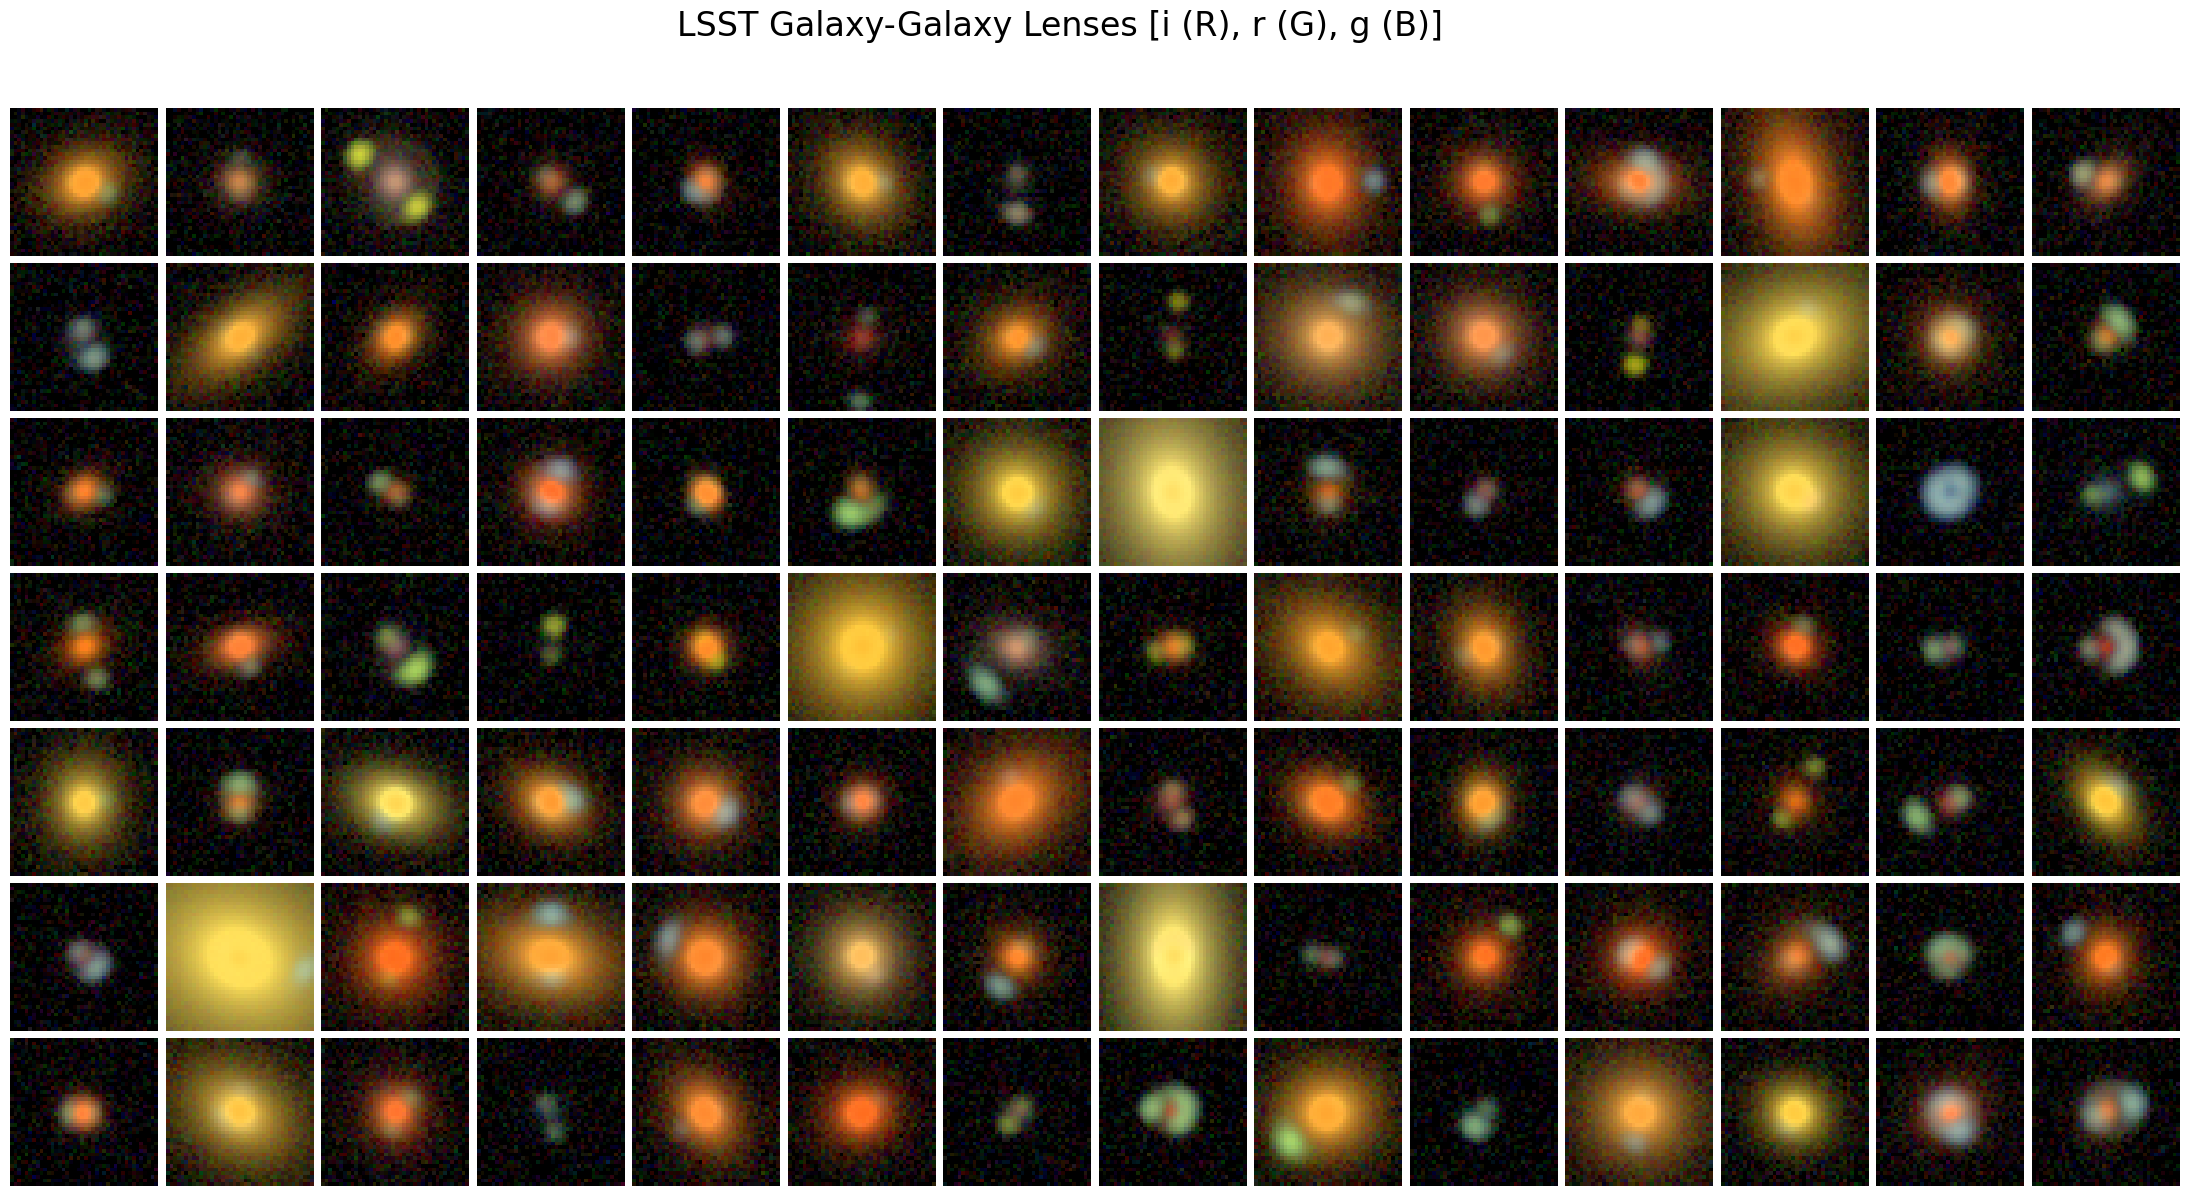

In [31]:
# Simulation settings
num_pix = 40
with_deflector = True
with_point_source = True
with_extended_source = True

# Lists to store the final images for the montage
lsst_GGL_rgb_images = []


# Generate Roman Mid Tier Quad Images
for i, lens in enumerate(selected_lenses_to_plot):

    # --- Roman Mid Tier Images ---
    lsst_bands = ["i", "r", "g"]
    lsst_images = {}
    for band in lsst_bands:
        img = simulate_image(
            lens_class=lens,
            band=band,
            observatory="LSST",
            num_pix=num_pix,
            add_noise=True,
            with_source=with_extended_source,
            with_deflector=with_deflector,
            with_point_source=with_point_source,
        )
        lsst_images[band] = img
    
    # Convert list to dictionary for easier handling
    

    # Create RGB
    rgb_lsst = get_composite_channels(
        image_dict=lsst_images,
        color_weights={
            "g": [0.0, 0.0, 1.0],
            "r": [0.0, 1.0, 0.0],
            "i": [1.0, 0.0, 0.0],
        },
        stretch=1
    )
    lsst_GGL_rgb_images.append(rgb_lsst)


# --- Plotting Function ---
def plot_montage(image_list, title, cmap=None):
    fig, axes = plt.subplots(7, 14, figsize=(28, 14))
    fig.suptitle(title, fontsize=24, y=0.95)

    for i, ax in enumerate(axes.flat):
        if i < len(image_list):
            # For RGB images (LSST/Roman), cmap is ignored by imshow usually
            # For single band (Euclid), we use 'gray'
            if cmap:
                ax.imshow(image_list[i], cmap=cmap, origin="lower")
            else:
                ax.imshow(image_list[i], origin="lower")
            ax.axis("off")
        else:
            ax.axis("off")

    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()


plot_montage(
    image_list=lsst_GGL_rgb_images,
    title="LSST Galaxy-Galaxy Lenses [i (R), r (G), g (B)]",
    cmap=None,
)